## ENVM1400 - I & A - Volta group - DGRE
made by: David Haasnoot

In [1]:
import glob
import os

# data/plot management
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import warnings

# plotting/mapmaknig
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow
import folium

warnings.simplefilter('ignore')

All data from the different sources is combined in this notebook

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
main_folder = os.path.dirname(home_path)

gis_folder = f'{main_folder}\\QGIS project'

Load in gis data

In [3]:
country_outline = gpd.read_file(f"{gis_folder}\\country_outline_32630.gpkg")
volta_outline = gpd.read_file(f"{gis_folder}\\volta_watershed_vector_32630.gpkg",crs="epsg:32630")
main_rivers = gpd.read_file(f"{gis_folder}\\main_rivers_volta.gpkg",crs="epsg:32630")

country_outline = country_outline.set_geometry(country_outline.geometry.to_crs('EPSG:4326'))
volta_outline = volta_outline.set_geometry(volta_outline.geometry.to_crs('EPSG:4326'))
main_rivers = main_rivers.set_geometry(main_rivers.geometry.to_crs('EPSG:4326'))

In [4]:
glob.glob("*.geojson")

['discharge_data_client.geojson',
 'discharge_data_reasearch_gate.geojson',
 'precipitation_data_client.geojson']

In [5]:
gdf_precip = gpd.read_file('precipitation_data_client.geojson',crs="EPSG:4326")
gdf_discharge_research_gate = gpd.read_file('discharge_data_reasearch_gate.geojson',crs="EPSG:4326")
gdf_discharge_client = gpd.read_file('discharge_data_client.geojson',crs="EPSG:4326")
gdf_discharge_client['name'] = gdf_discharge_client.apply(lambda x: x['name'].split(",")[-1][:-4].strip().lower(),axis=1)

In [6]:
gdf_discharge_client

,name,lat,lon,geometry
0,vonkoro,9.171205,-2.744841,POINT (-2.74484 9.17121)
1,dan,10.867876,-3.722479,POINT (-3.72248 10.86788)
2,samandeni,11.458715,-4.469477,POINT (-4.46948 11.45872)
3,dapola,10.572862,-2.914135,POINT (-2.91413 10.57286)
4,yakala,11.344608,-0.528965,POINT (-0.52897 11.34461)
5,yilou,12.999710,-1.570603,POINT (-1.57060 12.99971)
6,dakaye,11.777456,-1.600156,POINT (-1.60016 11.77746)
7,porga,11.045433,0.959914,POINT (0.95991 11.04543)
8,samboali,11.279537,1.015889,POINT (1.01589 11.27954)


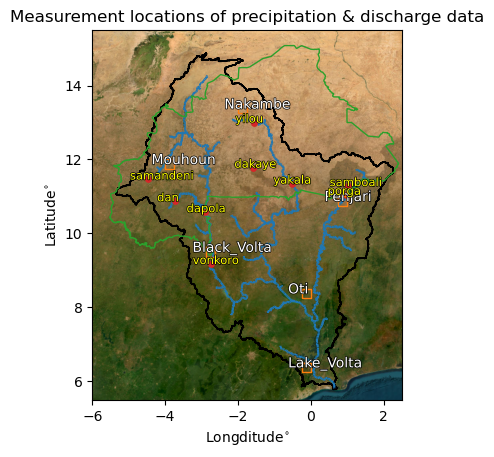

In [158]:
# quick way to get the bounds 
fig, ax = plt.subplots()

#adding features
volta_outline.plot(ax=ax,edgecolor="k", facecolor='none')
main_rivers.plot(ax=ax, color="C0",zorder=1)
country_outline.plot(ax=ax, facecolor="none", edgecolor="C2",zorder=6)

# get the bounds to add background
bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

# add stations
gdf_discharge_client.plot(ax=ax,color="C3",markersize=15,zorder=10)
with rasterio.open(get_background_map("stations", bounds_stations)) as r:
    rioshow(r, ax=ax)

gdf_precip.plot(ax=ax, facecolor="none",edgecolor="C1",zorder=10)

# add labels
mid_points = gdf_precip.geometry.centroid
for index, name in enumerate(gdf_precip.name):
    ax.annotate(f"{name}" , 
                (mid_points.iloc[index].x-0.5,mid_points.iloc[index].y),zorder=10, color="w",
                 path_effects=[matplotlib.patheffects.withStroke(linewidth=1, foreground="k")])

for index, name in enumerate(gdf_discharge_client.name):
    ax.annotate(f"{name}" , 
                (gdf_discharge_client.iloc[index].geometry.x-0.5,
                 gdf_discharge_client.iloc[index].geometry.y),zorder=10, color="yellow",
                 path_effects=[matplotlib.patheffects.withStroke(linewidth=1, foreground="k")],
                 fontsize="small")
# set appearance
ax.set_title("Measurement locations of precipitation & discharge data")
ax.set_xlabel("Longditude$^{\circ}$");
ax.set_ylabel("Latitude$^{\circ}$");

ax.set_ylim((5.5,15.5))
ax.set_xlim((-6,2.5));

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
984,10664588,10665503,10821582,4.36,870.4,1008.8,22.25,119470.4,0,169.104,7,1,4,1120850930,"MULTILINESTRING ((-2.68125 9.23125, -2.68542 9..."
1000,10670420,10671681,10821582,8.54,850.3,1029.0,61.47,121367.0,0,181.104,7,1,4,1120858080,"MULTILINESTRING ((-2.76875 9.13542, -2.76875 9..."


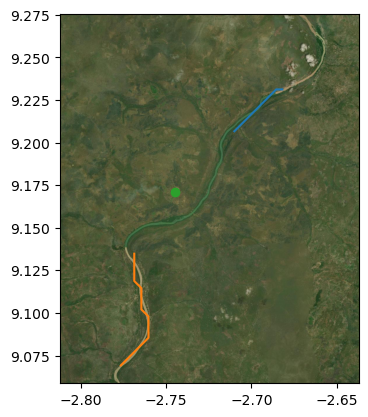

In [8]:
i=0
point_discharge = gdf_discharge_client.iloc[i].geometry.buffer(0.05)
selected_segement =  main_rivers[main_rivers.crosses(point_discharge)]

try:
    ax = selected_segement.iloc[[0]].plot()
    selected_segement.iloc[[1]].plot(ax=ax,color="C1")
    gdf_discharge_client.iloc[[i]].plot(ax=ax,color="C2")

    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
    with rasterio.open(get_background_map(f"river_selction_{i}", bounds_stations)) as r:
        rioshow(r, ax=ax)
except IndexError:
    print("no segement found")

selected_segement

In [9]:
point_discharge = gdf_discharge_client.iloc[i].geometry.buffer(0.05)
selected_segement =  main_rivers[main_rivers.crosses(point_discharge)]
selected_location = main_rivers.loc[selected_segement.index[0],:]
selected_location

HYRIV_ID                                               10664588
NEXT_DOWN                                              10665503
MAIN_RIV                                               10821582
LENGTH_KM                                                  4.36
DIST_DN_KM                                                870.4
DIST_UP_KM                                               1008.8
CATCH_SKM                                                 22.25
UPLAND_SKM                                             119470.4
ENDORHEIC                                                     0
DIS_AV_CMS                                              169.104
ORD_STRA                                                      7
ORD_CLAS                                                      1
ORD_FLOW                                                      4
HYBAS_L12                                            1120850930
geometry      (LINESTRING (-2.681250000000204 9.231249999999...
Name: 984, dtype: object

In [10]:
area_upstream_black_volta_border = selected_location.UPLAND_SKM

## load discharge & precipitation data from analysis

In [11]:
Rainfall_BF_msum = pd.read_excel("Monthly_sum_rainfall.xlsx",index_col=0)
Rainfall_BF_msum

,Black_Volta,Mouhoun,Nakambe,Penjari
Date,,,,
1981-01-31,0.410630,0.000000,0.000000,0.000000
1981-02-28,3.206854,0.440967,0.146212,0.000000
1981-03-31,90.963905,6.727890,2.109617,13.677208
1981-04-30,63.252223,17.095812,7.266831,69.913232
1981-05-31,140.261632,77.489709,35.860808,173.526988
...,...,...,...,...
2022-08-31,197.515479,283.810280,268.714974,266.400101
2022-09-30,242.311991,229.312312,143.299004,180.332295
2022-10-31,51.457809,25.429949,16.014090,84.981922


In [12]:
names = ['Black volta, vonkoro',
         'Bougouriba, dan',
         'Mou houn, black volta, samandeni',
         'Mou houn, black volta,dapola',
         'Nakanbe, white volta, yakala',
         'Nakanbe, white volta, yilou',
         'Nazinon, red volta, dakaye',
         'Pendjari, porga',
         'Singou, samboali']

In [13]:
df_discharge_per_location_lst = []
for name in names:
    df_discharge = pd.read_excel(f"{home_path}\\Combining data\\{name}.xlsx",index_col=0)
    df_discharge_per_location_lst.append(df_discharge)

# specific for black volta to start

In [14]:
discharge_black_volta = df_discharge_per_location_lst[0].rename(columns={"black volta, vonkoro":"Q"})

In [15]:
months_with_data = discharge_black_volta.apply(lambda x: f'{x.name.month}-{x.name.year}', axis=1).unique()

In [16]:
months_with_data

array(['1-1979', '2-1979', '3-1979', '4-1979', '5-1979', '6-1979',
       '7-1979', '8-1979', '9-1979', '10-1979', '11-1979', '12-1979',
       '1-1982', '2-1982', '3-1982', '4-1982', '5-1982', '6-1982',
       '7-1982', '8-1982', '9-1982', '10-1982', '11-1982', '12-1982',
       '1-1993', '2-1993', '3-1993', '4-1993', '5-1993', '6-1993',
       '7-1993', '8-1993', '9-1993', '10-1993', '11-1993', '12-1993'],
      dtype=object)

In [17]:
discharge_black_volta_msum = discharge_black_volta.resample('M').sum()
discharge_black_volta_msum['timestamp'] = discharge_black_volta_msum.apply(lambda x: x.name, axis=1)
discharge_black_volta_msum.index = \
                                discharge_black_volta_msum.apply(lambda x: f'{x.name.month}-{x.name.year}', axis=1)
discharge_black_volta_msum_sorted = discharge_black_volta_msum.loc[months_with_data]
discharge_black_volta_msum_sorted.index = discharge_black_volta_msum_sorted['timestamp']
discharge_black_volta_msum_sorted.drop(columns="timestamp",inplace=True)
discharge_black_volta_msum_sorted.head(5)

,Q
timestamp,
1979-01-31,253.0
1979-02-28,77.0
1979-03-31,18.0
1979-04-30,18.0
1979-05-31,1063.0


Q in m^3/s -> sum these is total m^3/s in one month -> m^3/month -> * 3600 * 24 * 30

In [18]:
discharge_black_volta_msum_sorted.Q = \
discharge_black_volta_msum_sorted.apply(lambda x: x.Q * x.name.days_in_month * 24 * 3600 , axis=1) #m^3/month

add column with month index for later

In [19]:
discharge_black_volta_msum_sorted["month"] = discharge_black_volta_msum_sorted.apply(lambda x: x.name.month, axis=1)

<AxesSubplot: xlabel='timestamp'>

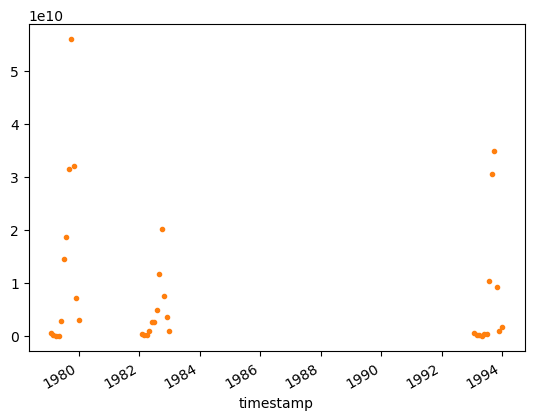

In [20]:
discharge_black_volta_msum_sorted.Q.plot(marker=".",lw=0,color="C1")

In [21]:
rainfall_black_volta = Rainfall_BF_msum[["Black_Volta"]].rename(columns={"Black_Volta":"P"})

<AxesSubplot: xlabel='Date'>

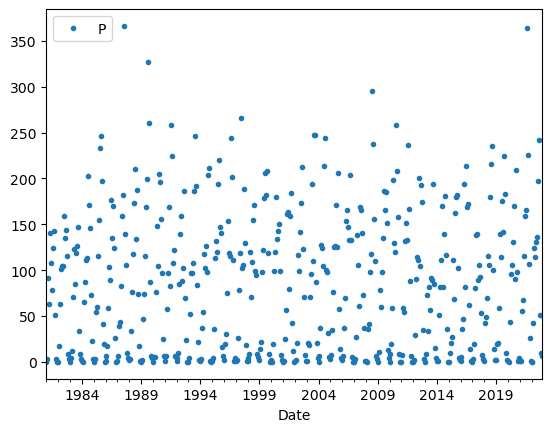

In [22]:
rainfall_black_volta.plot(marker=".",lw=0)

In [23]:
rainfall_black_volta # mm/month

,P
Date,
1981-01-31,0.410630
1981-02-28,3.206854
1981-03-31,90.963905
1981-04-30,63.252223
1981-05-31,140.261632
...,...
2022-08-31,197.515479
2022-09-30,242.311991
2022-10-31,51.457809


### convert precipitation to m^3/month

In [24]:
black_volta_basin_area = selected_location.UPLAND_SKM * 10**6  # km^2 -> m^2
rainfall_black_volta.P = rainfall_black_volta.P * black_volta_basin_area / 1000 # mm/month * m^2 ->/1000 =  m^3/month 

## Evaporation
Ensure the [Pyeto](https://github.com/woodcrafty/PyETo) package is present in your 
"C:\Users\{USERNAME}\anaconda3\envs\{ENVIRONMENT}\Lib\", 

In [25]:
from pyeto import thornthwaite, monthly_mean_daylight_hours, deg2rad

In [26]:
lat = deg2rad(gdf_discharge_client[gdf_discharge_client['name']=="vonkoro"].iloc[0].geometry.y)

Read file with temperature

In [27]:
df_temperature = pd.read_excel(f"{home_path}\\Evaporation\\mean_monthly_Near-Surface-Air-Temperature.xlsx",
                               index_col=0)
df_temperature.rename(columns={0:"Temperature"},inplace=True)
# df_temperature_msum = df_temperature.resample('M').sum()

In [28]:
df_temperature_msum = df_temperature.resample('M').sum()

In [29]:
gdf_discharge_client['name']

0      vonkoro
1          dan
2    samandeni
3       dapola
4       yakala
5        yilou
6       dakaye
7        porga
8     samboali
Name: name, dtype: object

Text(0.5, 1.0, 'Temperature data from EC-Earth3 historical model')

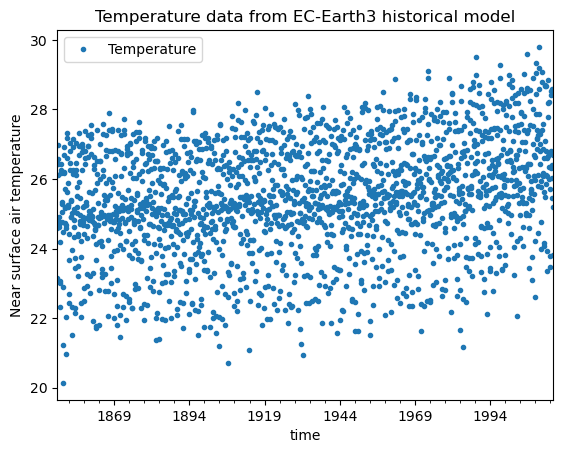

In [30]:
fig, ax = plt.subplots()
df_temperature_msum.plot(marker=".", lw=0,ax=ax)
ax.set_ylabel("Near surface air temperature")
ax.set_title("Temperature data from EC-Earth3 historical model")

mean between 6° W and 6°E and between 5°N and 15°N

In [31]:
mmdlh = monthly_mean_daylight_hours(lat, 2022)

In [32]:
month = np.arange(1,13,1)
df_light_hrs = pd.DataFrame(columns=['month',"daylight_hours"],data=list(zip(month, mmdlh)))
df_light_hrs.index = df_light_hrs.month
df_light_hrs.drop(columns="month",inplace=True)
df_light_hrs.head(3)

,daylight_hours
month,
1,11.531050
2,11.709220
3,11.950543


In [33]:
years = df_temperature_msum.index.year.unique()
for year in years:
    mmdlh = monthly_mean_daylight_hours(lat, year)
    # use thornthwaite to calculate the 
    evap = thornthwaite(df_temperature_msum[f'{year}'].Temperature.to_list(), mmdlh, year=year)
    set_items = df_temperature_msum[f'{year}'].index
    df_temperature_msum.loc[set_items,"evap"] = evap

In [34]:
df_temperature_msum.head()

,Temperature,evap
time,,
1850-01-31,23.142059,86.714085
1850-02-28,24.588379,96.747254
1850-03-31,26.426758,138.010137
1850-04-30,26.568604,138.825937
1850-05-31,26.962402,153.066451


<AxesSubplot: xlabel='time'>

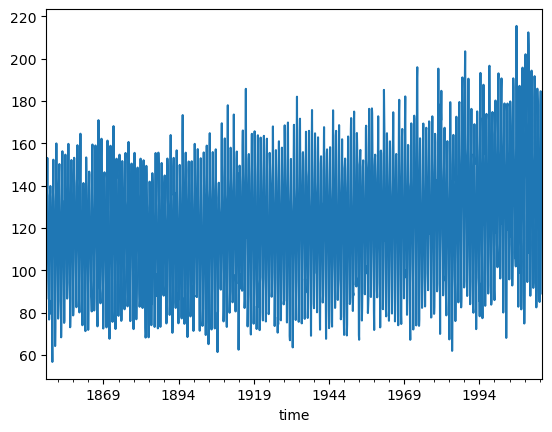

In [35]:
df_temperature_msum.evap.plot()

In [36]:
black_volta_basin_area = selected_location.UPLAND_SKM * 10**6  # km^2 -> m^2
df_temperature_msum["E"] = df_temperature_msum.evap * black_volta_basin_area / 1000 # mm/month * m^2 ->/1000 =  m^3/month 

# Combine data

In [37]:
combined_df = discharge_black_volta_msum_sorted.copy()
combined_df["P"] = rainfall_black_volta["P"]
combined_df["E"] = df_temperature_msum["E"]
combined_df["Diff"] = combined_df["P"] - combined_df["Q"] - combined_df["E"]

In [155]:
combined_df.head(5)

,Q,P,E,Diff
timestamp,,,,
1981-01-31,2678400.0,0.000000e+00,2.440339e+09,-2.443018e+09
1981-02-28,0.0,0.000000e+00,2.700824e+09,-2.700824e+09
1981-03-31,0.0,3.156125e+08,4.122239e+09,-3.806626e+09
1981-04-30,0.0,1.613304e+09,3.944054e+09,-2.330751e+09
1981-05-31,913334400.0,4.004274e+09,4.264245e+09,-1.173305e+09


# Plot combined data

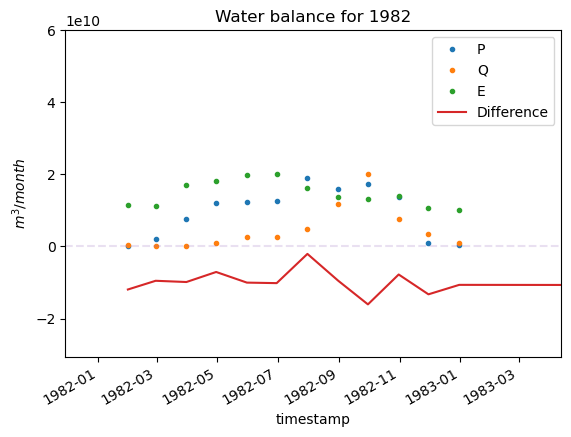

In [39]:
fig, ax = plt.subplots(1)
ax.set_xlabel("Date")
ax.set_ylabel("$m^3/month$")
for val in ["P","Q","E"]:
    combined_df[val].plot(marker='.',lw=0, ax=ax,label=val)
    
combined_df["Diff"].plot(ax=ax,label="Difference")
ax.set_xlim((4350,4850))
ax.get_xlim()
ax.set_title("Water balance for 1982")
ax.legend()
ax.axhline(0, alpha=0.2, ls="--", color="C4" )

In [40]:
yearly_sum = combined_df['1982'].sum()
print(f'{yearly_sum.P - yearly_sum.Q:.2g}m^3')

5.8e+10m^3


In [41]:
yearly_sum = combined_df['1982'].sum()
print(f'{yearly_sum.P - yearly_sum.Q - yearly_sum.E:.2g}')

-1.2e+11


optimize `factor_evap` so that yearly balance is 0

In [42]:
from scipy.optimize import root

Change to tweak:

In [43]:
year = discharge_black_volta_msum_sorted.index.year.unique()[1]

In [44]:
def fobj(factor_evap, lst_dfs, year, return_df=False):
    # unpack
    discharge_black_volta_msum_sorted = lst_dfs[0]
    rainfall_black_volta = lst_dfs[1]
    df_temperature_msum = lst_dfs[2]
    # combine
    combined_df_fit = discharge_black_volta_msum_sorted.copy()
    combined_df_fit["P"] = rainfall_black_volta["P"]
    combined_df_fit["E"] = factor_evap * df_temperature_msum["E"]
    combined_df_fit["Diff"] = combined_df_fit["P"] - combined_df_fit["Q"] - combined_df_fit["E"]
    
    # compute
    yearly_sum = combined_df_fit[f'{year}'].sum()
    out = yearly_sum.P - yearly_sum.Q - yearly_sum.E
    if return_df:
        return combined_df_fit
    else:
        return out

In [45]:
lst_dfs_fobj_input = [discharge_black_volta_msum_sorted, rainfall_black_volta, df_temperature_msum]
sol = root(fobj, 0.3, args=(lst_dfs_fobj_input, year))
sol.x[0]

0.33029259925797505

In [47]:
combined_fitted_df = fobj(sol.x[0], lst_dfs_fobj_input,year, True)
yearly_balance = fobj(sol.x[0], lst_dfs_fobj_input,year, False)
yearly_balance

7.62939453125e-06

In [104]:
def plot_combined_df(combined_df):    
    fig, ax = plt.subplots(1)
    ax.set_xlabel("Date")
    ax.set_ylabel("$m^3/month$")
    for val in ["P","Q","E"]:
        combined_df[val].plot(marker='.',lw=0.5, ax=ax,label=val)

    combined_df["Diff"].plot(ax=ax,label="Difference")
    ax.get_xlim()
    ax.set_title(f"Water balance")
    ax.legend()
    ax.axhline(0, alpha=0.2, ls="--", color="C4" )

# make general:

#### load precipitation data from analysis

In [105]:
Rainfall_BF_msum = pd.read_excel("Monthly_sum_rainfall.xlsx",index_col=0)
Rainfall_BF_msum.columns

Index(['Black_Volta', 'Mouhoun', 'Nakambe', 'Penjari'], dtype='object')

#### load discharge data from analysis

In [106]:
names = ['black volta, vonkoro',
         'bougouriba, dan',
         'mou houn, black volta, samandeni',
         'mou houn, black volta,dapola',
         'nakanbe, white volta, yakala',
         'nakanbe, white volta, yilou',
         'nazinon, red volta, dakaye',
         'pendjari, porga',
         'singou, samboali']

need a dictionary to link discharge to precipitation stations

In [107]:
q_p_linking_dictionary = {'black volta, vonkoro': 'Black_Volta',
                          'bougouriba, dan': 'Mouhoun',
                          'mou houn, black volta, samandeni': 'Mouhoun',
                          'mou houn, black volta,dapola': 'Black_Volta',
                          'nakanbe, white volta, yakala': 'Nakambe',
                          'nakanbe, white volta, yilou': 'Nakambe',
                          'nazinon, red volta, dakaye': 'Nakambe',
                          'pendjari, porga': 'Penjari',
                          'singou, samboali': 'Penjari'}

In [108]:
df_discharge_per_location_lst = []
for name in names:
    df_discharge = pd.read_excel(f"{home_path}\\Combining data\\{name}.xlsx",index_col=0)
    df_discharge_per_location_lst.append(df_discharge)

## Q

In [111]:
df_discharge_lst = []
for index, df in enumerate(df_discharge_per_location_lst):
    name = names[index]
    df_discharge_location = df_discharge_per_location_lst[index].rename(columns={name:"Q"})
    # get month with data
    months_with_data = df_discharge_location.apply(lambda x: f'{x.name.month}-{x.name.year}', axis=1).unique()
    
    # get monthly sum
    df_discharge = df_discharge_location.resample('M').sum()
    
    # do indexing magic to discard non-data-eyars
    df_discharge['timestamp'] = df_discharge.apply(lambda x: x.name, axis=1)
    df_discharge.index = df_discharge.apply(lambda x: f'{x.name.month}-{x.name.year}', axis=1)
    df_discharge = df_discharge.loc[months_with_data]
    df_discharge.index = df_discharge['timestamp']
    df_discharge.drop(columns="timestamp",inplace=True)
    df_discharge.Q = df_discharge.apply(lambda x: x.Q * x.name.days_in_month * 24 * 3600 , axis=1)
    df_discharge_lst.append(df_discharge)


## E

In [121]:
df_temperature = pd.read_excel(f"{home_path}\\Evaporation\\mean_monthly_Near-Surface-Air-Temperature.xlsx",
                       index_col=0)
df_temperature.rename(columns={0:"Temperature"},inplace=True)
df_temperature_msum = df_temperature.resample('M').sum()

In [122]:
years = df_temperature_msum.index.year.unique()
for year in years:
    mmdlh = monthly_mean_daylight_hours(lat, year)
    # use thornthwaite to calculate the 
    evap = thornthwaite(df_temperature_msum[f'{year}'].Temperature.to_list(), mmdlh, year=year)
    set_items = df_temperature_msum[f'{year}'].index
    df_temperature_msum.loc[set_items,"evap"] = evap

In [128]:
def fobj_generalised(factor_evap, lst_dfs, year, return_df=False):
    # unpack
    df_discharge = lst_dfs[0]
    rainfall_selected_basin = lst_dfs[1]
    df_local_evaporation = lst_dfs[2]
    
    combined_df = df_discharge.copy()
    combined_df["P"] = rainfall_selected_basin["P"]
    combined_df["E"] = factor_evap * df_local_evaporation["E"]
    combined_df["Diff"] = combined_df["P"] - combined_df["Q"] - combined_df["E"]
    combined_df = combined_df.loc[combined_df.P.dropna().index] # remove lack of Precipitation data

    # compute
    yearly_sum = combined_df[f'{year}'].sum()
    out = yearly_sum.P - yearly_sum.Q - yearly_sum.E
    if return_df:
        return combined_df_fit
    else:
        return out

# now run per station:

In [160]:
output_coefficients_df = []
for station_index in range(len(names)):
    # get corresponding names
    station_name = names[station_index]
    station_precip = q_p_linking_dictionary[station_name]

    # do geoanalysis
    point_discharge = gdf_discharge_client.iloc[station_index].geometry.buffer(0.05)
    selected_segement =  main_rivers[main_rivers.crosses(point_discharge)]
    
    if len(selected_segement) < 1:
        print("no river segment found")
        # error in finding river segment, we stop
    else:
        # get the first segment to enter the buffer around the station
        selected_location = main_rivers.loc[selected_segement.index[0],:]
        # retreive the area
        selected_basin_area = selected_location.UPLAND_SKM* 10**6  # km^2 -> m^2

        # get precipitation
        rainfall_selected_basin = Rainfall_BF_msum[[station_precip]].rename(columns={station_precip:"P"})
        rainfall_selected_basin.P = rainfall_selected_basin.P * selected_basin_area / 1000 # mm/month * m^2 ->/1000 

        # get evaporation
        df_local_evaporation = df_temperature_msum[['evap']] * selected_basin_area / 1000 # mm/month * m^2 ->/1000 
        df_local_evaporation.rename(columns={'evap':'E'},inplace=True)
        ### do initial compute, but E will be too high
        combined_df = df_discharge_lst[station_index].copy()
        combined_df["P"] = rainfall_selected_basin["P"]
        combined_df["E"] = df_local_evaporation["E"]
        combined_df["Diff"] = combined_df["P"] - combined_df["Q"] - combined_df["E"]
        combined_df = combined_df.loc[combined_df.P.dropna().index] # remove lack of Precipitation data
        # some cases no overlap in data
        if len(combined_df) > 0:
#             plot_combined_df(combined_df)
            lst_coefficients = []
            for year in combined_df.index.year.unique():
                lst_dfs_fobj_input = [df_discharge_lst[station_index], rainfall_selected_basin, df_local_evaporation]
                sol = root(fobj_generalised, 1.2, args=(lst_dfs_fobj_input, year))
                lst_coefficients.append(sol.x[0])

            location_lst = [station_name for i in range(len(lst_coefficients))]
            output_df = pd.DataFrame(columns=['Year',"Factor","Location"],
                                     data=list(zip(combined_df.index.year.unique(), lst_coefficients, location_lst)))
            output_df.index.name = station_name
            output_coefficients_df.append(output_df)
    

no river segment found
no river segment found
no river segment found


In [184]:
combined_factors = pd.concat(output_coefficients_df)
combined_factors.sort_values("Year",inplace=True)

(-0.5, 0.5)

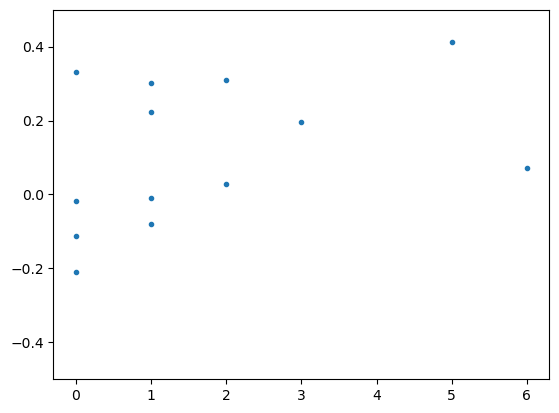

In [187]:
fig, ax = plt.subplots(1)
combined_factors["Factor"].plot(marker='.', lw=0,ax=ax)
ax.set_ylim(-0.5,0.5)